In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt
import cvxpy

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 49.99999999999944


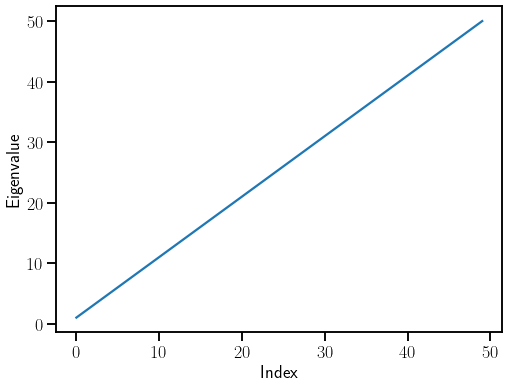

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "CG PR": solvers.fo.ConjugateGradientPR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(2e-2)),
     "BFGS": solvers.fo.BFGS(f, grad_f),
     "DFP": solvers.fo.DFP(f, grad_f),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -1.5449471722647004
Norm of gradient = 0.010767463393602947
	 Newton
Required tolerance achieved!
Convergence in 1 iterations
Function value = -1.544975674669407
Norm of gradient = 3.2165373641803314e-14
	 CG quad
Required tolerance achieved!
Convergence in 36 iterations
Function value = -1.5449756746693981
Norm of gradient = 112.74085510932213
	 CG FR
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -1.544975672001932
Norm of gradient = 0.0003562338528136053
	 CG PR
Required tolerance achieved!
Convergence in 84 iterations
Function value = -1.5449756746693395
Norm of gradient = 9.723575565874838e-07
	 BB 1
Required tolerance achieved!
Convergence in 78 iterations
Function value = -1.544975674668965
Norm of gradient = 9.496784709733391e-07
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -1.5449754834354514
Norm of gradient = 0.0011777360378583037


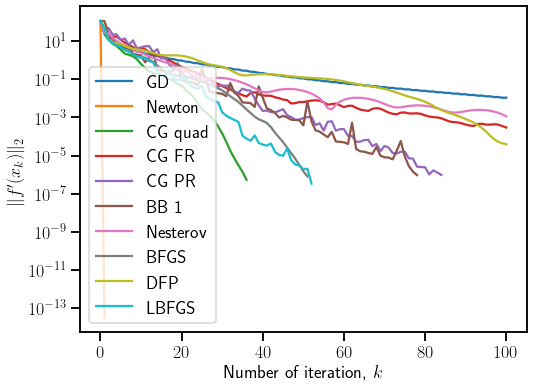

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [9]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
736 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Newton
423 µs ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG quad
366 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
2.33 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
510 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
758 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 BFGS
1.84 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 DFP
2.97 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 LBFGS
2.61 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000002747


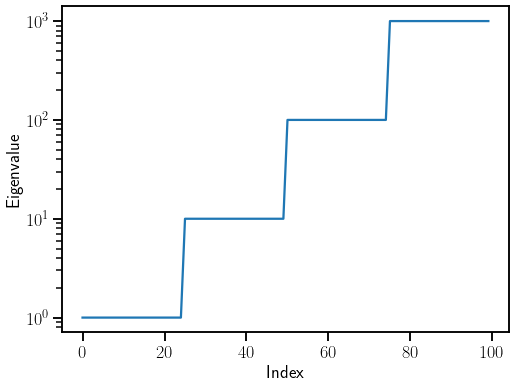

In [8]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [9]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [26]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
#      "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5,
                                                                     init_alpha=1., beta=0.3)),
     "CG PR": solvers.fo.ConjugateGradientPR(f, grad_f, ss.Backtracking("Armijo", rho=0.5,
                                                                     init_alpha=1., beta=0.3)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3)),
     "BFGS": solvers.fo.BFGS(f, grad_f)
    }

In [27]:
x0 = np.random.rand(n)
tol = 1e-4
max_iter = 100

In [28]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -5.194937083347763
Norm of gradient = 2.8663776027840058
	 CG quad
Required tolerance achieved!
Convergence in 4 iterations
Function value = -8.970464323105286
Norm of gradient = 1547.4143504602002
	 CG FR
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -8.970464265764551
Norm of gradient = 0.004549118725305892
	 CG PR
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -8.9704344732615
Norm of gradient = 0.033986040327229135
	 BB 1
Required tolerance achieved!
Convergence in 42 iterations
Function value = -8.97046432264943
Norm of gradient = 9.572576567269648e-05
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -6.773408286812105
Norm of gradient = 2.1532973339746335
	 BFGS
Required tolerance achieved!
Convergence in 23 iterations
Function value = -8.97046432310518
Norm of gradient = 3.670199816409566e-06


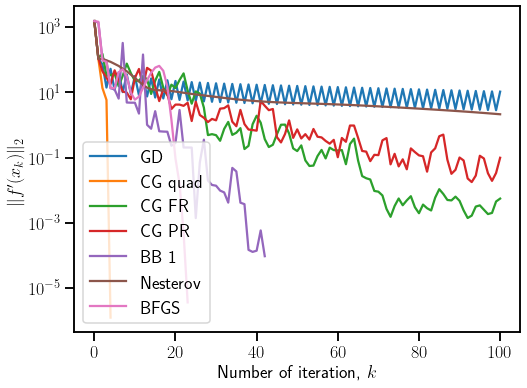

In [29]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [24]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
3.69 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
622 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG quad
185 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
25.1 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
1.91 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
3 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BFGS
6.63 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Analytical center of the set of inequalities

In [30]:
n = 3000
m = 100
A = np.random.rand(m, n) * 10

In [31]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) \
                           + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.T / (1 - A.dot(x))**2).dot(A) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

class hess_matvec(object):
    def __init__(self, x):
        self._x = x
    
    def dot(self, y):
        d_part = y * 2 * (1 + self._x**2) / (1 - self._x**2)**2
        m_part = (A.T / (1 - A.dot(self._x))**2).dot(A.dot(y))
        return m_part + d_part

In [32]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
    "CG PR": solvers.fo.ConjugateGradientPR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             ),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "Inexact Newton": solvers.so.InexactNewtonMethod(f, grad_f, hess_matvec, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "BFGS": solvers.fo.BFGS(f, grad_f),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [33]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 50

In [34]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=1)

	 GD Armijo
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6800574449442
Norm of gradient = 4.871426039740505e-07
	 Newton


/var/folders/r2/8fwp8hwn29q_slh9d8yh34gc0000gn/T/ipykernel_42384/271951084.py:1: RuntimeWarning: invalid value encountered in log
  f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))


Required tolerance achieved!
Convergence in 14 iterations
Function value = -706.680057444944
Norm of gradient = 1.5295403655545238e-06
	 CG FR
Required tolerance achieved!
Convergence in 13 iterations
Function value = -706.6800574449375
Norm of gradient = 6.0787800996398e-06
	 CG PR
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.680057444933
Norm of gradient = 8.556528713402099e-06
	 BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6800574449405
Norm of gradient = 5.422047381664391e-06
	 Nesterov
Required tolerance achieved!
Convergence in 46 iterations
Function value = -706.6800574449351
Norm of gradient = 8.415566609096969e-06
	 Inexact Newton
Required tolerance achieved!
Convergence in 16 iterations
Function value = -706.6800574449442
Norm of gradient = 3.182952378965428e-07
	 GD Lipschitz
Required tolerance achieved!
Convergence in 36 iterations
Function value = -706.6800574449312
Norm of gradient = 7.391065103239

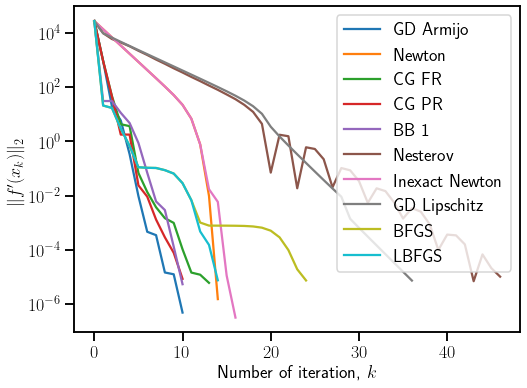

In [35]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [48]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD Armijo


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


23.3 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
5.21 s ± 775 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 CG FR


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


31.2 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
8.76 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


122 ms ± 56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Inexact Newton
91 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 GD Lipschitz


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


71.2 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.58 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 LBFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


61.5 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Toy logistic regression with L2 regularization

In [20]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 3.333142980636552


In [21]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [22]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [23]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD Armijo
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.49178449410694014
Norm of gradient = 0.0036765053292285165
	 Newton
Required tolerance achieved!
Convergence in 17 iterations
Function value = 0.49178030927888144
Norm of gradient = 6.87485954540363e-06
	 CG FR
Required tolerance achieved!
Convergence in 55 iterations
Function value = 0.491780309287277
Norm of gradient = 9.717319785380935e-06
	 BB 1
Required tolerance achieved!
Convergence in 58 iterations
Function value = 0.4917803092779409
Norm of gradient = 2.47335690668093e-06
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.49178034493193723
Norm of gradient = 0.0005506293467817073
	 GD Lipschitz
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.4917861185562149
Norm of gradient = 0.006172810200676787
	 LBFGS
Required tolerance achieved!
Convergence in 35 iterations
Function value = 0.49178030928328686
Norm of gradient = 5.27972132

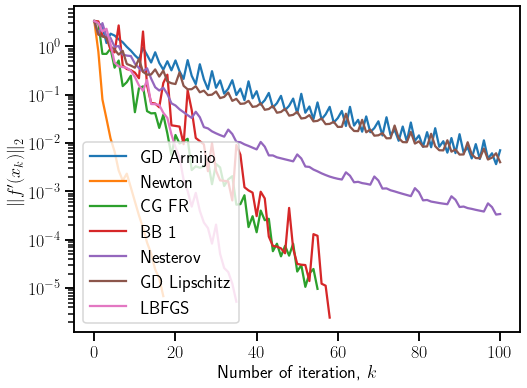

In [24]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [58]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD Armijo
122 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
132 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 CG FR
63 ms ± 7.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
8.99 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
76 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 GD Lipschitz
64.6 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 LBFGS
28.1 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Non-smooth optimization
### Toy SVM classifier

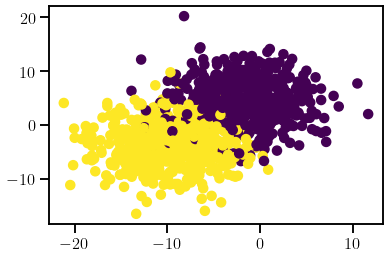

In [25]:
import sklearn.datasets as skldata
n = 2
m = 1000
C = 1
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4, random_state=1)
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], c=y)

### CVXPy solver

In [26]:
tol = 1e-5
max_iter = 300

In [28]:
w = cvxpy.Variable(n)
b = cvxpy.Variable()
obj = 0.5 * cvxpy.norm2(w)**2 + C * cvxpy.sum(cvxpy.maximum(0, 1 - cvxpy.multiply(y, (X @ w - b))))
problem = cvxpy.Problem(cvxpy.Minimize(obj))
problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
b = b.value
w = np.array(w.value)
print("Optimal objective = {}".format(obj.value))
print("Train accuracy = {}".format(np.mean(y == np.sign(X.dot(w) - b).ravel())))

Optimal objective = 172.28516543088344
Train accuracy = 0.938


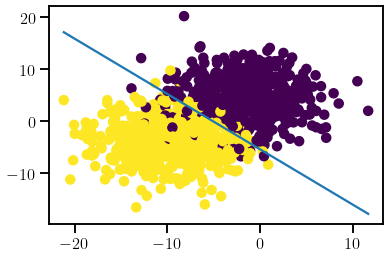

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.linspace(min(X[:, 0]), max(X[:, 0]))
plt.plot(x, (b - w[0] * x) / w[1])

In [30]:
def hinge_loss(w, X, y, C):
    return 0.5 * np.linalg.norm(w)**2 + C * np.sum(np.maximum(0, 1 - y * X.dot(w)))

def subgrad_hinge_loss(w, X, y, C):
    nnz = 1 - y * X.dot(w)
    subgrad_part = X * y[:, np.newaxis]
    return w - C * np.sum(subgrad_part[nnz > 0], axis=0)

X_ones = np.hstack((X, np.ones((m, 1))))
f = lambda x: hinge_loss(x, X_ones, y, C)
subgrad = lambda x: subgrad_hinge_loss(x, X_ones, y, C)

In [31]:
m_dict = {"Subgrad method": solvers.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
          "Dual averaging": solvers.fo.DualAveraging(f, subgrad, ss.InvIterStepSize(), ss.ScaledConstantStepSize(1.0)),
          "Adaptive subgrad": solvers.fo.SubgradientMethod(f, subgrad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-3, init_alpha=1))
         }

In [32]:
x0 = np.random.randn(n+1)

In [33]:
for key in m_dict:
    print("\t {}".format(key))
    x = m_dict[key].solve(x0, max_iter, tol, disp=True)
    print("Train accuracy = {}".format(np.mean(y == np.sign(X_ones.dot(x)))))

	 Subgrad method
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 388.31332951046875
Train accuracy = 0.926
	 Dual averaging
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 353.2649493118556
Norm of gradient = 788.1371187880648
Train accuracy = 0.855
	 Adaptive subgrad
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 174.80357645499186
Train accuracy = 0.941


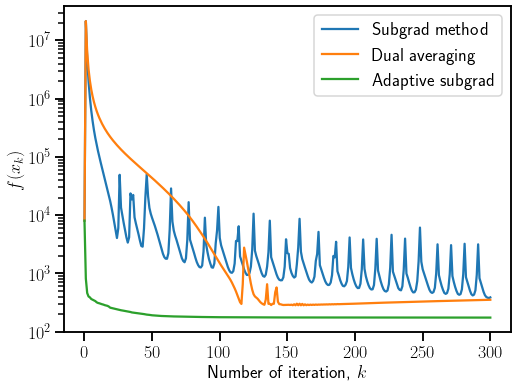

In [34]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([f(x) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [75]:
print("\t SCS CVXPy")
%timeit problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 SCS CVXPy
35 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Subgrad method
24.7 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Dual averaging
34.2 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Adaptive subgrad
84.8 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
